# Solving ODE with KAN

In [1]:
from kan import *
from kan.utils import create_dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

#checking if device is gpu or cpu 
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(str(device) + ': ' + torch.cuda.get_device_name(0))

cuda: NVIDIA GeForce GTX 1060 6GB


In [55]:
#function for initial point of differential equation df = R*f*(1-f)
def fx(x):
    f=1/(1+torch.exp(-x))
    return(f)

R=1.0
xB = torch.tensor([[0.0]],requires_grad=True,device=device)
fB = torch.tensor([[fx(xB)]],requires_grad=True,device=device)

n_epochs = 250
batch_size = 20
lrate = 0.01
domain = (-2.5,2.5)

#creating the KAN model
model = KAN(width=[1,15,1], grid=5, k=3, seed=42, device=device)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [56]:
import time
losstep = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    x = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    f = model(x)
    df = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
    boundary = model(xB) - fB
    df_residual = (df - R*f*(1-f))
    
    loss = loss_fn(df_residual,torch.zeros_like(df_residual))+loss_fn(boundary,torch.zeros_like(boundary))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci} %), latest loss {loss}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')


Finished epoch 24 (10 %), latest loss 0.010005110530438337
Finished epoch 49 (20 %), latest loss 0.007880250350155018
Finished epoch 74 (30 %), latest loss 0.00015981247614758355
Finished epoch 99 (40 %), latest loss 0.001013980976903661
Finished epoch 124 (50 %), latest loss 0.0008347085460739403
Finished epoch 149 (60 %), latest loss 0.0004659067619934268
Finished epoch 174 (70 %), latest loss 3.67285488898402e-05
Finished epoch 199 (80 %), latest loss 8.629091524699498e-06
Finished epoch 224 (90 %), latest loss 3.3184929148541567e-05
Finished epoch 249 (100 %), latest loss 2.2548981634198987e-05
Total time: 0.2 min


Accuracy sample points: 0.0010573656763881445


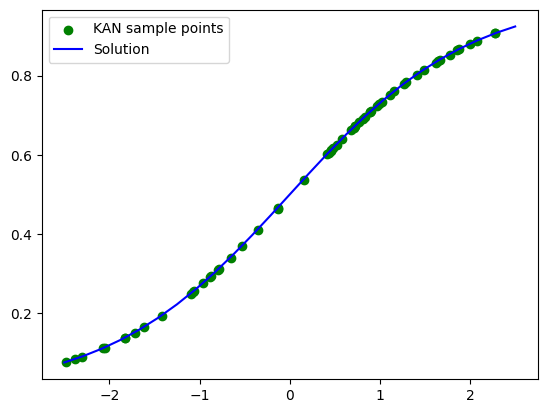

In [57]:
#verify mean difference of sample points
xt=(domain[0]-domain[1])*torch.rand(batch_size*3, 1,device=device)+domain[1]
yt=model(xt)
ys=fx(xt)
accuracy = (ys - yt).float().mean()
print(f'Accuracy sample points: {accuracy}')

#plot points vs solution
xs=torch.linspace(domain[0],domain[1],25,device=device)
ys=fx(xs)

xt=xt.reshape(-1,).detach().cpu().numpy()
yt=yt.reshape(-1,).detach().cpu().numpy()
xs=xs.reshape(-1,).detach().cpu().numpy()
ys=ys.reshape(-1,).detach().cpu().numpy()

plt.scatter(xt,yt,label='KAN sample points', color='g')
plt.plot(xs,ys,label='Solution',color='b')
plt.legend()
plt.show()

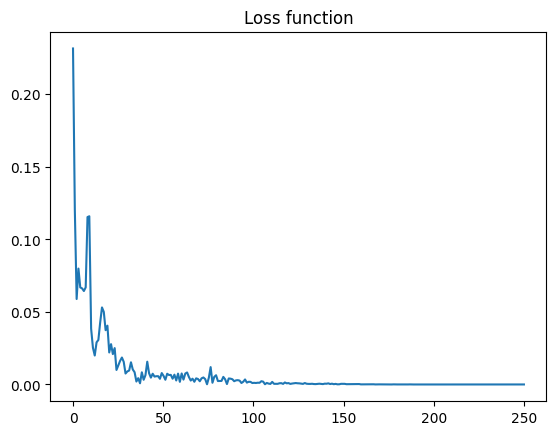

In [58]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Loss function')
plt.show()

In [6]:
#function for initial point of differential equation df = f
def fx(x):
    f=torch.exp(x)
    return(f)

xB = torch.tensor([[0.0]],requires_grad=True,device=device)
fB = torch.tensor([[fx(xB)]],requires_grad=True,device=device)

n_epochs = 250
batch_size = 40
lrate = 0.1
domain = (-2.0,2.0)

#creating the KAN model
model1 = KAN(width=[1,15,1], grid=5, k=3, seed=42, device=device)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model1.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [7]:
#training the model
import time
losstep = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    x = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    f = model1(x)
    df = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
    boundary = model1(xB) - fB
    df_residual = (df - f)
    
    loss = loss_fn(df_residual,torch.zeros_like(df_residual))+loss_fn(boundary,torch.zeros_like(boundary))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci} %), latest loss {loss}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')


Finished epoch 24 (10 %), latest loss 0.04558280910948865
Finished epoch 49 (20 %), latest loss 0.005350502705328559
Finished epoch 74 (30 %), latest loss 0.00149486192625697
Finished epoch 99 (40 %), latest loss 0.00033891762326504975
Finished epoch 124 (50 %), latest loss 0.0036233627367496923
Finished epoch 149 (60 %), latest loss 0.0026274078595616046
Finished epoch 174 (70 %), latest loss 0.0015262166889607105
Finished epoch 199 (80 %), latest loss 0.0009442124888708623
Finished epoch 224 (90 %), latest loss 0.004234031969850751
Finished epoch 249 (100 %), latest loss 0.00047526062124264855
Total time: 0.2 min


Accuracy sample points: -0.00041784936911426485


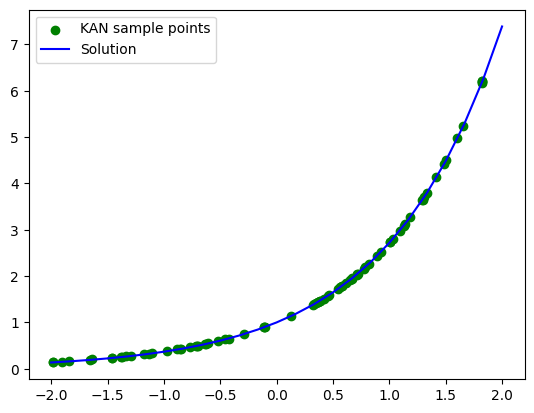

In [8]:
#verify mean difference of sample points
xt=(domain[0]-domain[1])*torch.rand(batch_size*2, 1,device=device)+domain[1]
yt=model1(xt)
ys=fx(xt)
accuracy = (ys - yt).float().mean()
print(f'Accuracy sample points: {accuracy}')

#plot points vs solution
xs=torch.linspace(domain[0],domain[1],25,device=device)
ys=fx(xs)

xt=xt.reshape(-1,).detach().cpu().numpy()
yt=yt.reshape(-1,).detach().cpu().numpy()
xs=xs.reshape(-1,).detach().cpu().numpy()
ys=ys.reshape(-1,).detach().cpu().numpy()

plt.scatter(xt,yt,label='KAN sample points', color='g')
plt.plot(xs,ys,label='Solution',color='b')
plt.legend()
plt.show()

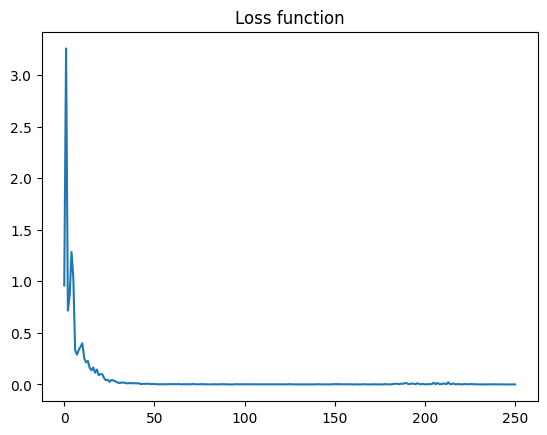

In [9]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Loss function')
plt.show()

In [28]:
# solving an exaple of linear system dx = ax + by, dy = cx + dy

def x1(t):
    xt=torch.exp(-t)
    return(xt)

def x2(t):
    xt=-2.0*torch.exp(-t)
    return(xt)

a=1.0
b=1.0
c=4.0
d=1.0

t1=torch.tensor(0.0,requires_grad=True,device=device)
vB = torch.tensor([[x1(t1),x2(t1)]],requires_grad=True,device=device)
wx=1
wy=1
wb=1

# parameters for model
n_epochs = 2250
batch_size = 40
lrate = 0.15
domain = (-0.75,1.25)
sample_size=2*batch_size

modelsys = KAN(width=[1,40,2], grid=5, k=3, seed=42, device=device)

loss_fn = nn.MSELoss()  
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)

checkpoint directory created: ./model
saving model version 0.0


In [29]:
#training the model
import time
losstep = []
lossxl = []
lossyl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    t = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(t)

    #dv = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    x = v[:,0].reshape(batch_size,1)
    y = v[:,1].reshape(batch_size,1)
    dx = torch.autograd.grad(x.sum(), t, create_graph=True)[0]
    dy = torch.autograd.grad(y.sum(), t, create_graph=True)[0]
    #dv = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    
    dx_residual = a*x + b*y - dx
    dy_residual = c*x + d*y - dy
    #dv_residual = a*x + b*y + c*x + d*y - dv
    bd = modelsys(torch.tensor([[t1]],requires_grad=True,device=device)) - vB
    
    lossx =loss_fn(dx_residual,torch.zeros_like(dx_residual))
    lossy =loss_fn(dy_residual,torch.zeros_like(dy_residual))
    loss = (wx*lossx + wy*lossy + wb*loss_fn(bd,torch.zeros_like(bd)))
    #loss = loss_fn(dv_residual,torch.zeros_like(dv_residual))+loss_fn(bd,torch.zeros_like(bd))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(f'Finished epoch {epoch}, latest loss {loss}')
    losstep.append(loss.detach().cpu().numpy())
    lossxl.append(lossx.detach().cpu().numpy())
    lossyl.append(lossy.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch}, ({prci}%), latest loss {loss}, x_loss: {lossx}, y_loss: {lossy}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 224, (10%), latest loss 0.00020229241783429534, x_loss: 0.00013695371898102778, y_loss: 5.719374714253423e-05
Finished epoch 449, (20%), latest loss 6.984044448697593e-05, x_loss: 4.4737354902454825e-05, y_loss: 1.924749667532689e-05
Finished epoch 674, (30%), latest loss 0.0027518366783551343, x_loss: 0.00022258336270811923, y_loss: 0.0024041610213377165
Finished epoch 899, (40%), latest loss 0.0105693893728205, x_loss: 0.0023797142115239223, y_loss: 0.007753652099154459
Finished epoch 1124, (50%), latest loss 0.020476233489756038, x_loss: 0.007680654830290884, y_loss: 0.012261272688483583
Finished epoch 1349, (60%), latest loss 0.0003260131154724596, x_loss: 7.239262655691037e-05, y_loss: 0.0002504265872986668
Finished epoch 1574, (70%), latest loss 3.127979716215585e-05, x_loss: 1.6341760028479454e-05, y_loss: 1.3386300512654661e-05
Finished epoch 1799, (80%), latest loss 0.08159143375498511, x_loss: 0.004648023457610786, y_loss: 0.05692213496380516
Finished epoch 202

Accuracy x1 sample points: 0.008414560928940773, Accuracy x2 sample points: 0.016151336953043938


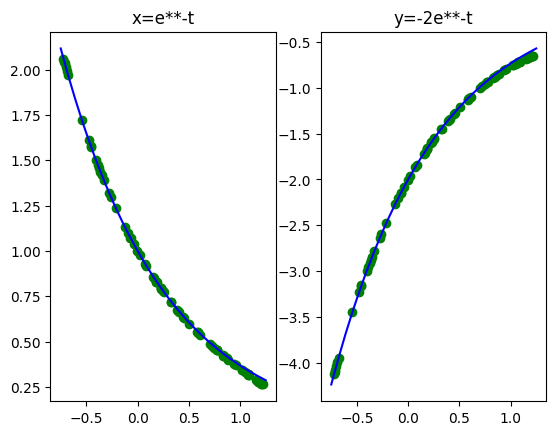

In [32]:
#verify mean difference of sample points
ti=(domain[0]-domain[1])*torch.rand(sample_size, 1,device=device)+domain[1]
vi=modelsys(ti)
xi=vi[:,0].reshape(sample_size,1)
yi=vi[:,1].reshape(sample_size,1)
x1s=x1(ti)
x2s=x2(ti)
acc1 = (x1s - xi).float().mean()
acc2 = (x2s - yi).float().mean()
print(f'Accuracy x1 sample points: {acc1}, Accuracy x2 sample points: {acc2}')

xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
ts=torch.linspace(domain[0],domain[1],30)

figure, axis = plt.subplots(1, 2)
axis[0].scatter(ti,xi,color='g')
axis[0].plot(ts.detach().cpu().numpy(),x1(ts).detach().cpu().numpy(),color='b')
axis[0].set_title('x=e**-t')
axis[1].scatter(ti,yi,color='g')
axis[1].plot(ts.detach().cpu().numpy(),x2(ts).detach().cpu().numpy(),color='b')
axis[1].set_title('y=-2e**-t')
plt.show()

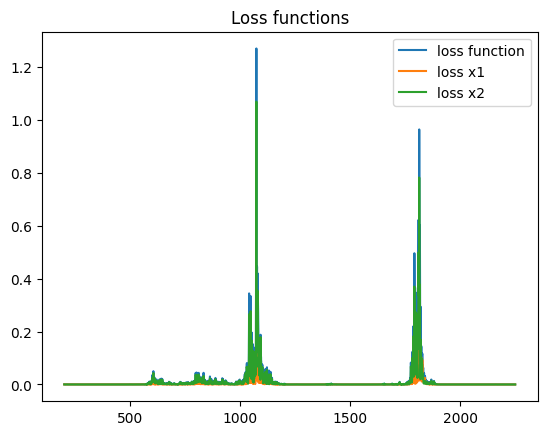

In [38]:
step1=200
plt.plot(np.linspace(0,n_epochs,n_epochs)[step1:n_epochs],losstep[step1:n_epochs], label='loss function')
plt.plot(np.linspace(0,n_epochs,n_epochs)[step1:n_epochs],lossxl[step1:n_epochs],label='loss x1')
plt.plot(np.linspace(0,n_epochs,n_epochs)[step1:n_epochs],lossyl[step1:n_epochs],label='loss x2')
plt.title('Loss functions')
plt.legend()
plt.show()